<a href="https://colab.research.google.com/github/Fuenfgeld/DMA2024TeamC/blob/main/Code/DWH_GeoVisualisierung_HS_GS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kursarbeit Datenmanagement und -Archivierung WS 23/24**

Master-Code Name-CALICO:MA


**Explorative Datenanalyse**

> Laden Libraries

In [ ]:
import pandas as pd
import sqlite3
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
import folium
from folium import plugins
import numpy as np

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive



Verbindung zur Datenbank



In [ ]:
#connect to DB
#conn = sqlite3.connect('/content/drive/MyDrive/Datenmanagement_und_Archivierung_im_Umfeld_der_Forschung/CALICO_MA/datawarehouse_new.db')
conn = sqlite3.connect('/content/drive/MyDrive/calico_ma_repo/Data/CALICO_MA_Database/CALICO_MA.db')
#conn = sqlite3.connect('/home/gunnar/DMA2024TeamC/Data/CALICO_MA_Database/CALICO_MA.db')    
cur = conn.cursor()

print("Datenbank wurde erfolgreich geöffnet")

Datenbank wurde erfolgreich geöffnet


In [ ]:
print(pd.read_sql_query('''
SELECT name FROM sqlite_master
WHERE type='table'
ORDER BY name;
     ''', conn))

            name
0     encounters
1    facts_table
2  immunizations
3    medications
4   observations
5       patients
6     procedures



Die Tabellen werden aus der Datenbank in die DataFrames geladen.




In [ ]:
df_encounters = pd.read_sql_query("SELECT * FROM encounters", conn)
df_facts_table = pd.read_sql_query("SELECT * FROM facts_table", conn)
df_immunizations = pd.read_sql_query("SELECT * FROM immunizations", conn)
df_medications = pd.read_sql_query("SELECT * FROM medications", conn)
df_observations = pd.read_sql_query("SELECT * FROM observations", conn)
df_patients = pd.read_sql_query("SELECT * FROM patients", conn)
df_procedures = pd.read_sql_query("SELECT * FROM procedures", conn)

Nur die facts_table Tabelle für die Analyse benötigt.

In [ ]:
# Überprüfung der facts_table
df3 = df_facts_table.head(3)
print(df3)

     cancer_type                            patient_ID encounter_ID  \
0  Breast_Cancer  d2061cc7-bee0-0e6c-3ac4-15c197c474e0         None   
1  Breast_Cancer  073d8e80-ff90-1c8d-57e4-29bfca52c87f         None   
2  Breast_Cancer  e1ff7e68-4097-9faf-514d-e4cfcfdf252e         None   

   patient_LAT  patient_LON    patient_COUNTY  patient_ZIP  \
0    42.359926   -71.113260  Middlesex County       2140.0   
1    42.257845   -72.026317  Worcester County       1535.0   
2    42.204290   -71.818449  Worcester County       1545.0   

   patient_HEALTHCARE_EXPENSES  patient_HEALTHCARE_COVERAGE patient_BIRTHDATE  \
0                   1475230.00                      4244.64        1956-06-22   
1                   1489125.00                      4016.36        1964-08-28   
2                     57142.44                      2103.20        1998-08-28   

  observations_CODE  observations_VALUE     observations_DATE  \
0              QALY                63.0  2020-06-22T10:47:46Z   
1          

Anzahl der Tupeln in facts_table:

cancer_type
Breast_Cancer        1011
Colorectal_Cancer    1027
Lung_Cancer          1016
Name: patient_ID, dtype: int64


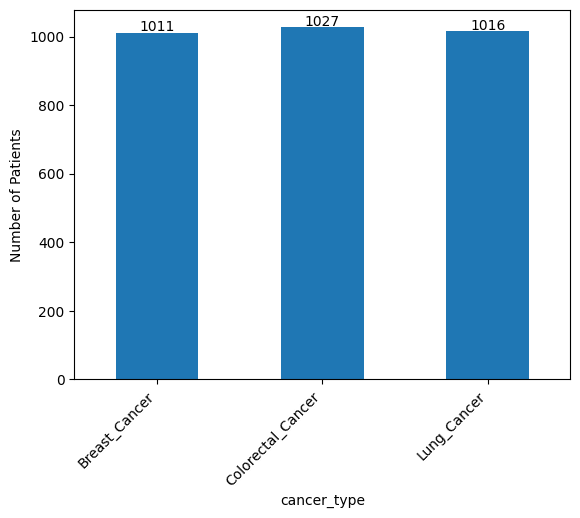

In [ ]:
df4 = df_facts_table.groupby(['cancer_type'])['patient_ID'].count()
print(df4)
ax = df4.plot.bar()
plt.ylabel('Number of Patients')
plt.xticks(rotation=45, ha='right')

for i, v in enumerate(df4):
    ax.text(i, v + 5, int(v), ha='center')

plt.show()

Abbildungen

1.   Kosten fur jeder krebsarten (Insgesamt)
2.   Kosten fur jeder krebsarten (getrennt)
3.   Life quality (QALY) mit kosten korrelieren (Insgesamt) (death date not available)
4.   Life quality (QALY) mit kosten korrelieren (getrennt)
5.   Verhaltnis QALY - aktuelle alter (von BIRTHDATE (patients))
6.   Statistiche auswertung

# A. Gesamte Kosten für jede Krebsart


## A.1. Einlesen des Life costs und der Cancer costs für jede Krebsart.

Die Life costs bestehen aus den HEALTHCARE EXPENSES und den HEALTHCARE COVERAGE für das ganze Leben, wobei EXPENSES vom Patienten und COVERAGE von der Insurance getragen werden.

Die Cancer Costs bestehen aus der Summe der Kosten, die durch Medications, Procedures und immunizations verursacht worden sind.

In [ ]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_HEALTHCARE_EXPENSES as life_expenses,
        f.patient_HEALTHCARE_COVERAGE AS life_coverage,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_costs,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS cancer_costs
        FROM facts_table f
;''')

df_Costs = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'life_expenses', 'life_coverage', 'life_costs', 'cancer_costs'])


## A.2. Darstellung der gesamten Life Kosten (aggregated values, with confidence intervals), d.h. Summe der HEALTHCARE_EXPENSES und HEALTHCARE_COVERAGE, für jede Krebsart.

> Lebzeitkosten für die Die Brustkrebs Patienten sind am höchsten.

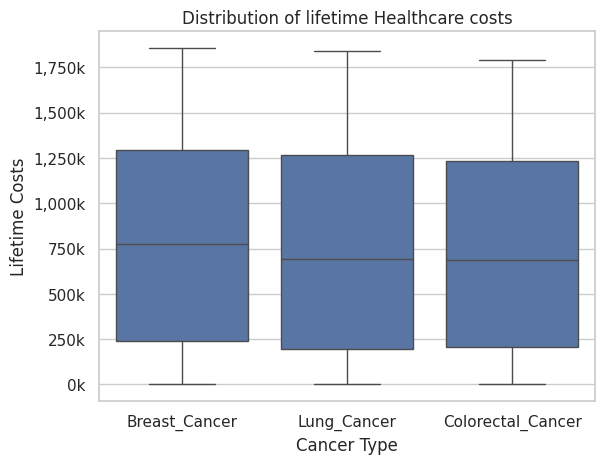

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_costs")
g.set_title("Distribution of lifetime Healthcare costs")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime Costs')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Lifetime_costs_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Lifetime_costs_for_all.png", format='png')

## A.3. Darstellung der HEALTHCARE_EXPENSES (aggregated values, with confidence intervals) für jede Krebsart.

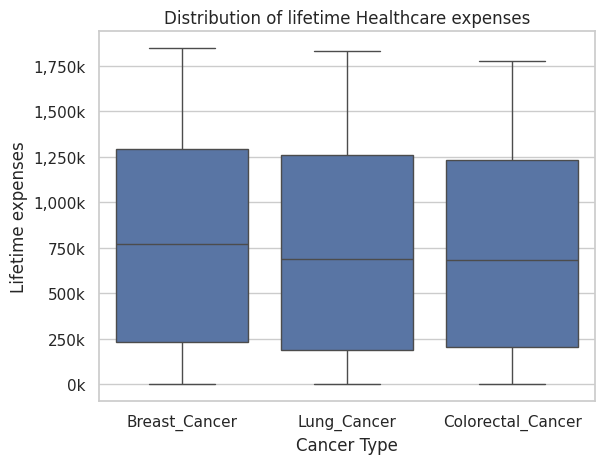

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_expenses")
g.set_title("Distribution of lifetime Healthcare expenses")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime expenses')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_expenses_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Lifetime_costs_for_all.png", format='png')

## A.4. Darstellung der HEALTHCARE_COVERAGE (aggregated values, with confidence intervals) für jede Krebsart.

> Die Kosten, die von der Insurance übernommen worden sind, sind viel niedriger als diejenigen, die vom Patienten bezahlt worden sind.

Number of outliers: 346
Outliers:
            cancer_type  life_expenses  life_coverage  life_costs  \
12        Breast_Cancer        3745.64           0.00     3745.64   
14        Breast_Cancer     1623235.00        5822.84  1629057.84   
18        Breast_Cancer       32909.74         444.96    33354.70   
26        Breast_Cancer        2712.36           0.00     2712.36   
45        Breast_Cancer     1315197.72       10202.88  1325400.60   
...                 ...            ...            ...         ...   
2993  Colorectal_Cancer     1666640.00        5707.76  1672347.76   
3007  Colorectal_Cancer     1635250.00        6315.24  1641565.24   
3023  Colorectal_Cancer      307287.37        5829.48   313116.85   
3044  Colorectal_Cancer        5967.18           0.00     5967.18   
3051  Colorectal_Cancer      113125.65        9621.89   122747.54   

      cancer_costs  
12         2449.84  
14       421351.84  
18         1348.40  
26         3961.48  
45         3107.00  
...        

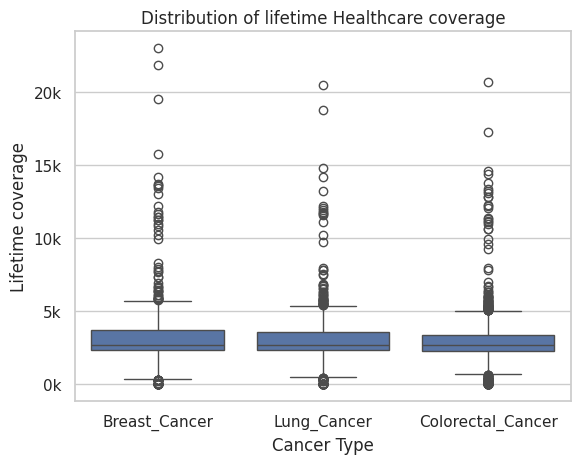

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="life_coverage")
g.set_title("Distribution of lifetime Healthcare coverage")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime coverage')

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_coverage_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_coverage_for_all.png", format='png')



Ein schneller Test mit der IQR (interquartile range) Methode

In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = df_Costs['life_coverage'].quantile(0.25)
Q3 = df_Costs['life_coverage'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df_Costs[(df_Costs['life_coverage'] < Q1 - 1.5*IQR) | (df_Costs['life_coverage'] > Q3 + 1.5*IQR)]

print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)

Number of outliers: 346
Outliers:
            cancer_type  life_expenses  life_coverage  life_costs  \
12        Breast_Cancer        3745.64           0.00     3745.64   
14        Breast_Cancer     1623235.00        5822.84  1629057.84   
18        Breast_Cancer       32909.74         444.96    33354.70   
26        Breast_Cancer        2712.36           0.00     2712.36   
45        Breast_Cancer     1315197.72       10202.88  1325400.60   
...                 ...            ...            ...         ...   
2993  Colorectal_Cancer     1666640.00        5707.76  1672347.76   
3007  Colorectal_Cancer     1635250.00        6315.24  1641565.24   
3023  Colorectal_Cancer      307287.37        5829.48   313116.85   
3044  Colorectal_Cancer        5967.18           0.00     5967.18   
3051  Colorectal_Cancer      113125.65        9621.89   122747.54   

      cancer_costs  
12         2449.84  
14       421351.84  
18         1348.40  
26         3961.48  
45         3107.00  
...        

Ein schneller Test mit der IQR (interquartile range) Methode

## A.5. Darstellung der gesamten Cancer Kostenverteilung (aggregated values, with confidence intervals). Es ist die Summe der Kosten, die durch Medications, Procedures und immunizations verursacht worden sind.

> Die höchsten Kosten findet man bei den Colorectal Cancer patients.

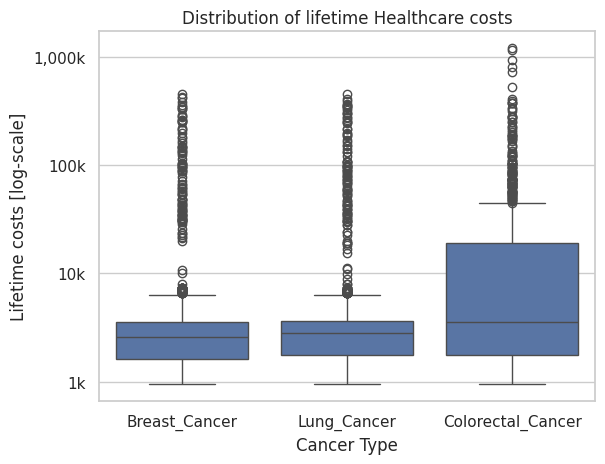

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.boxplot(data=df_Costs, x="cancer_type", y="cancer_costs")
g.set_title("Distribution of lifetime Healthcare costs")
plt.xlabel('Cancer Type')
plt.ylabel('Lifetime costs [log-scale]')

# Set y-axis to logarithmic scale
g.set_yscale("log")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_for_all.png", format='png')

Ein schneller Test mit der IQR (interquartile range) Methode

In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = df_Costs['cancer_costs'].quantile(0.25)
Q3 = df_Costs['cancer_costs'].quantile(0.75)
IQR = Q3 - Q1

# Define outliers
outliers = df_Costs[(df_Costs['cancer_costs'] < Q1 - 1.5*IQR) | (df_Costs['cancer_costs'] > Q3 + 1.5*IQR)]

print("Number of outliers:", len(outliers))
print("Outliers:")
print(outliers)

Number of outliers: 505
Outliers:
            cancer_type  life_expenses  life_coverage  life_costs  \
14        Breast_Cancer     1623235.00        5822.84  1629057.84   
23        Breast_Cancer       98706.48        2826.40   101532.88   
24        Breast_Cancer     1409750.00        4103.80  1413853.80   
27        Breast_Cancer     1097307.42        2870.60  1100178.02   
33        Breast_Cancer      427338.18        2769.84   430108.02   
...                 ...            ...            ...         ...   
3040  Colorectal_Cancer       18710.00        1264.55    19974.55   
3044  Colorectal_Cancer        5967.18           0.00     5967.18   
3046  Colorectal_Cancer     1442870.00        3813.04  1446683.04   
3051  Colorectal_Cancer      113125.65        9621.89   122747.54   
3052  Colorectal_Cancer      231267.49        5119.56   236387.05   

      cancer_costs  
14       421351.84  
23        23823.67  
24       198125.95  
27        45063.68  
33        31068.25  
...        

## A.6. Berechnung der QALY Werte für alle Krebsarten

Die qualitätsadjustierten Lebensjahre (QALYs, engl. = Quality-Adjusted Life Years) erscheinen als "QALY" in den Quelldateien und werden unter dem Attribut "observations_VALUE" in der Faktentabelle gespeichert.

Die qualitätsadjustierten Lebensjahre einer Person werden bestimmt, indem man die erwartete Dauer jedes Gesundheitszustandes mit dem Nutzwert dieses Zustandes gewichtet. Das eigentliche QALY bewegt sich in einem Skalenbereich von 1 bis 0, wobei ein QALY von 1 ein Jahr in voller Gesundheit bedeutet, während ein QALY von 0 dem Tod entspricht.

Für unsere Analyse wird QALY als Verhältnis zwischen "observations_VALUE" und Alter zum Zeitpunkt der Observation "observations_AGE" berechnet und in die Variable "QALY_Wert" gespeichert. Im ETL wurde dafür gesorgt, dass die Faktentabelle nur strikt positive Werte von "observations_AGE" enthält.

In [ ]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
;''')


df_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
df3 = df_QALY.head(3)
print(df3)



     cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY  64.0   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY  56.0   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY  22.0   21.0   0.954545   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  


## A.7. Frequenz der QALY Werte in dem Datensatz

Die Darstellung der Anzahl an vorhandenen QALY Werten für jede Krebsart zeigt eine sehr inhomogene Verteilung der Daten. Die meisten Daten bewegen sich in dem Bereich von 0,9 bis 1,0.

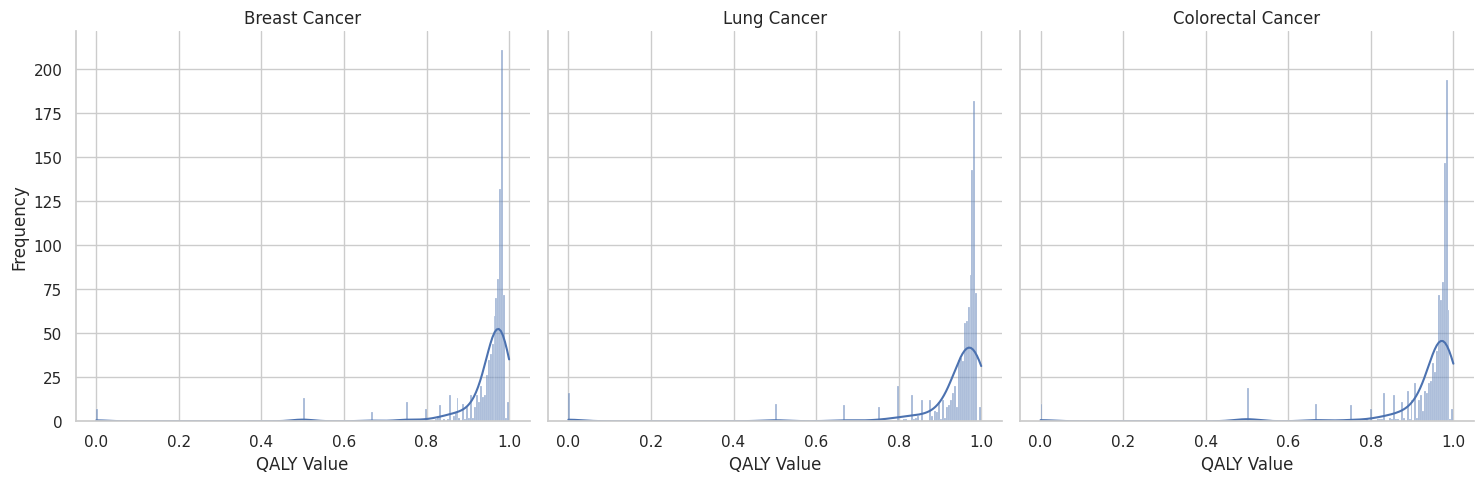

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.displot(data=df_QALY, x="QALY_Wert", col="cancer_type", kind="hist", kde=True)

# Set individual titles
for ax in g.axes.flat:
    title = ax.get_title().split('=')[1].strip()
    ax.set_title(title.replace('_', ' '))

# Set x and y axis labels
g.set_axis_labels('QALY Value', 'Frequency')

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/QALY_Datensatz_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/QALY_Datensatz_for_all.png", format='png')

## A.8. Altersverteilung im Datensatz

/tmp/ipykernel_1290725/3873657954.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(labels)


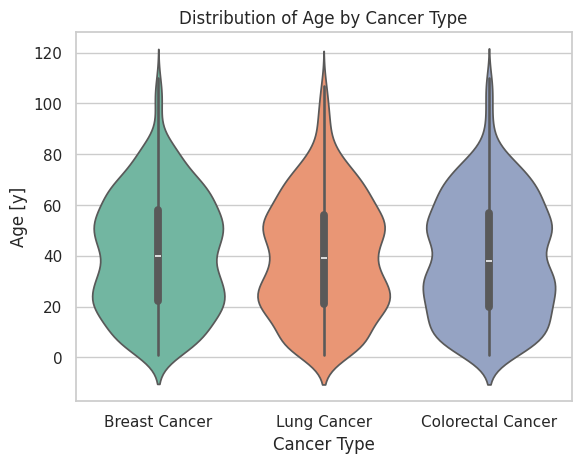

In [ ]:
sns.set_theme(style="whitegrid")

# Use a color palette
g = sns.violinplot(data=df_QALY, x="cancer_type", y="Age", hue="cancer_type", palette='Set2', legend=False)
g.set_title("Distribution of Age by Cancer Type")
plt.xlabel('Cancer Type')
plt.ylabel('Age [y]')

# Replace underscore in x-axis labels
labels = [label.get_text().replace('_', ' ') for label in g.get_xticklabels()]
g.set_xticklabels(labels)

plt.savefig("//content/drive/MyDrive/calico_ma_repo/Documentation/Alter_Datensatz_for_all.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Alter_Datensatz_for_all.png", format='png')

## A.9. Gesamte Geografische Verteilung

Darstellung mit folium der gesamte geografischen Verteilung. Der Wohnungsort jedes Patienten wird auf der Karte von Massachusetts mit Hilfe seiner LAT und LON Koordinaten eingetragen.

In [ ]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_p = df_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_p)):
    folium.RegularPolygonMarker(coordinates_p[i], radius = 1, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa)
map_massa


## A.10. Cancer costs vs. Age

Die Cancer Kosten erhöhen sich ab ca. 60 Jahre für alle Krebsarten.

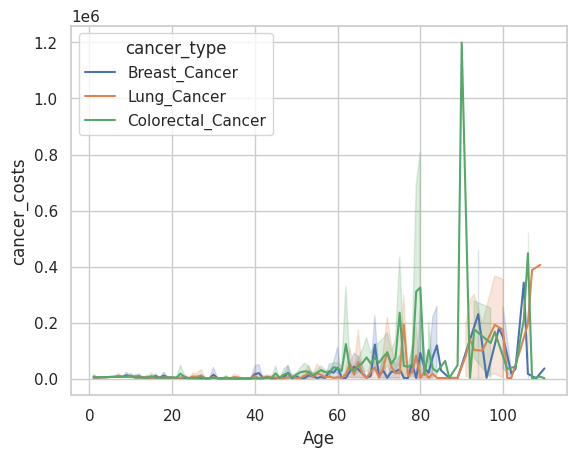

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.lineplot(
    data=df_QALY, x="Age", y="cancer_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_age.png", format='png')

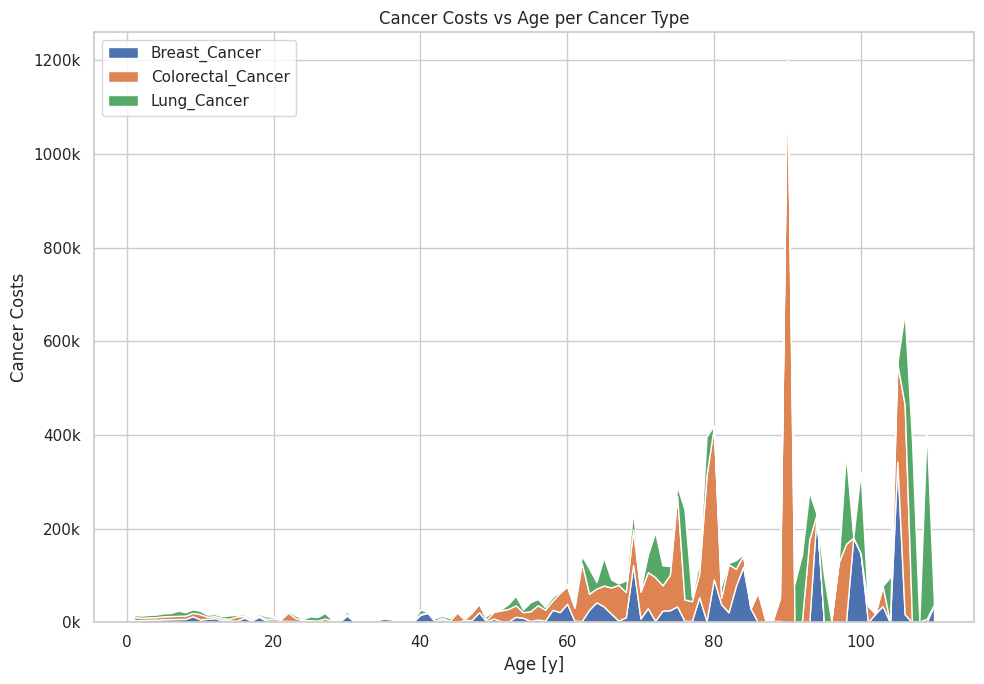

In [ ]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Reshape the data
df_pivot = df_QALY.pivot_table(index='Age', columns='cancer_type', values='cancer_costs', fill_value=0)

# Create a stacked area plot
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(df_pivot.index, df_pivot.T, labels=df_pivot.columns)
ax.legend(loc='upper left')
ax.set_title('Cancer Costs vs Age per Cancer Type')
ax.set_xlabel('Age [y]')
ax.set_ylabel('Cancer Costs')
ax.yaxis.set_major_formatter(formatter)
plt.tight_layout()

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_age.png", format='png')

## A.11. LIFE HEALTHCARE Kosten vs. Alter

Die gesamte Life Healthcare Kosten steigen mit dem Alter.

Es gibt zwei Bereiche: ein mit niedrigen Kosten und ein mit hohen Kosten.

Beide zeigen eine lineare Abhängigkeit mit dem Alter.

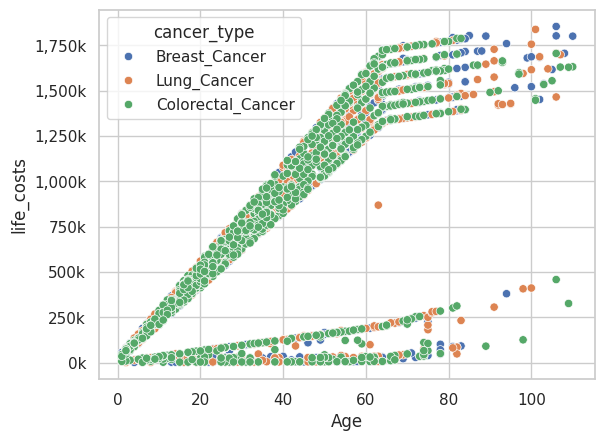

In [ ]:
g = sns.scatterplot(
    data=df_QALY, x="Age", y="life_costs", hue="cancer_type")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_age.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_age.png", format='png')

## A.12. Cancer costs vs. QALY

Höhere Cancer costs sind mit höheren QALY Werte verbunden.

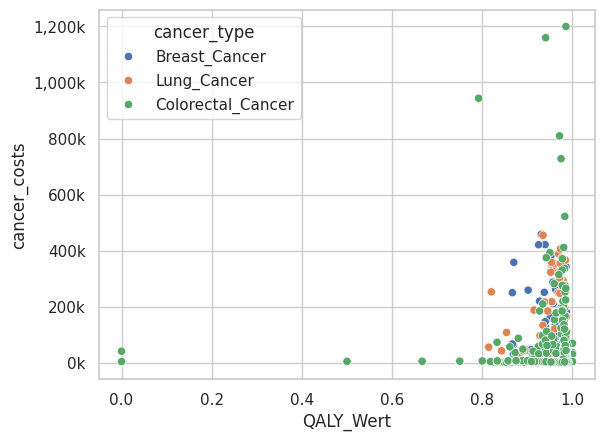

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="cancer_costs", hue="cancer_type")

# Format y-axis labels
formatter = ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'k')
g.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_QALY.png", format='png')

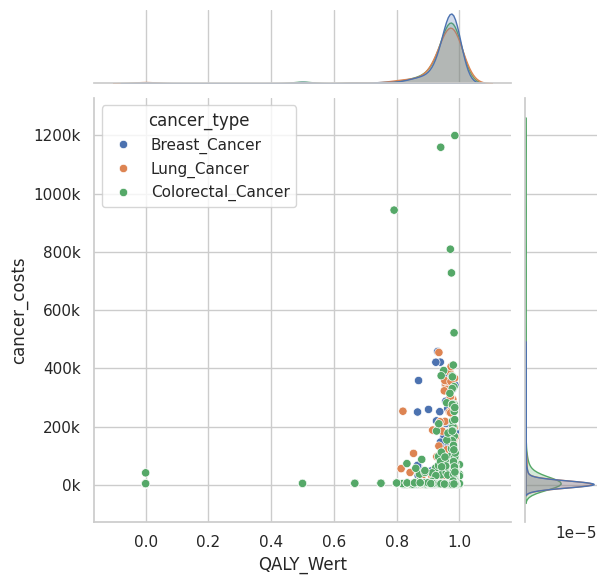

In [ ]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Create a joint plot with larger marginal charts
g = sns.jointplot(data=df_QALY, x="QALY_Wert", y="cancer_costs", hue="cancer_type")

# Format y-axis labels
g.ax_joint.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Cancer_costs_vs_QALY.png", format='png')

## A.13. Life HEALTHCARE Kosten vs. QALY

Höhere Life HEALTHCARE Kosten sind mit höheren QALY Werte verbunden.

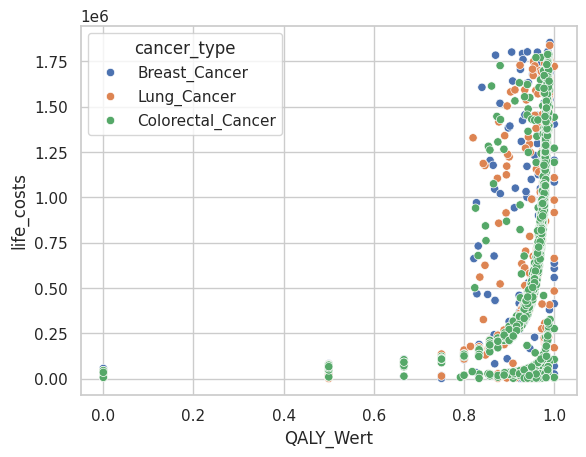

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_QALY, x="QALY_Wert",y="life_costs", hue="cancer_type")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_QALY.png", format='png')

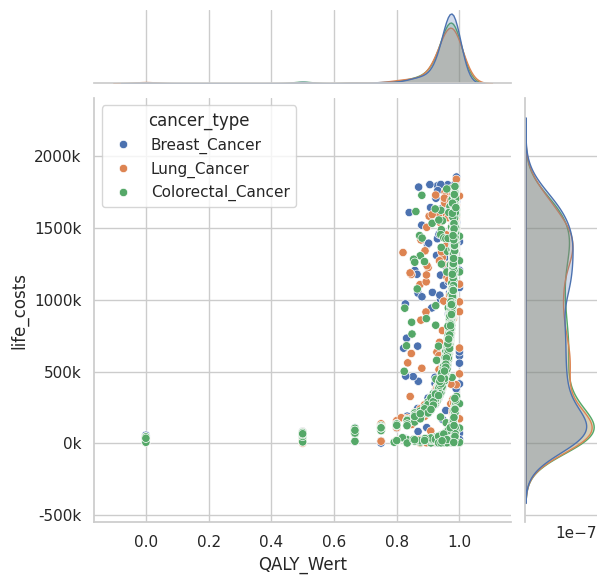

In [ ]:
# Function to format y-axis tick values
def thousands(x, pos):
    'The two args are the value and tick position'
    return '%1.0fk' % (x * 1e-3)

formatter = FuncFormatter(thousands)

# Create a joint plot with larger marginal charts
g = sns.jointplot(data=df_QALY, x="QALY_Wert", y="life_costs", hue="cancer_type")

# Format y-axis labels
g.ax_joint.yaxis.set_major_formatter(formatter)

plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY.png", format='png')
#plt.savefig("/home/gunnar/DMA2024TeamC/Documentation/Life_costs_vs_QALY.png", format='png')

# B. Lungenkrebs Patients

## B.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Lungenkrebs Patienten

In [ ]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Lung_Cancer"
;''')

df_lung_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
#result = df_lung.head(50)
#print(result)




## B.2. Geografische Verteilung der Lungenkrebs Patienten

Darstellung mit folium der geografischen Verteilung der Lung Cancer Patienten. Der Wohnungsort jedes Patienten wird auf der Karte von Massachusetts mit Hilfe seiner LAT und LON Koordinaten eingetragen.

In [ ]:
MASSA_COORDINATES =(42.407211, -71.382439)
map_massa_lung = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_lung = df_lung_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_lung)):
    folium.RegularPolygonMarker(coordinates_lung[i], radius = 3, fill_color = "red", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_lung)
map_massa_lung

## B.3. Verteilung der vorhandenen QALY Werte bei Lungenkrebs Patienten

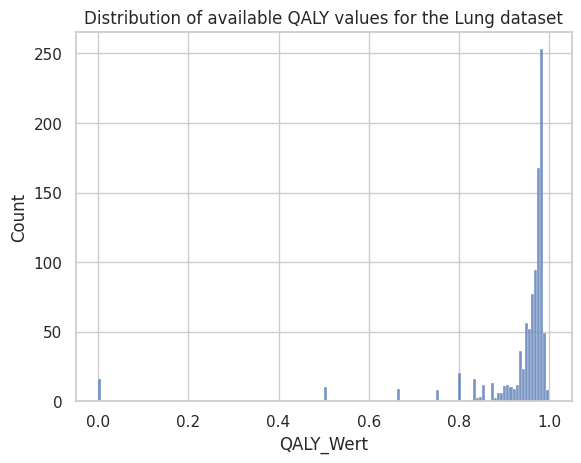

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_lung_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Lung dataset")

## B.4. Cancer Kosten als Funktion vom QALY für Lungenkrebs Patienten

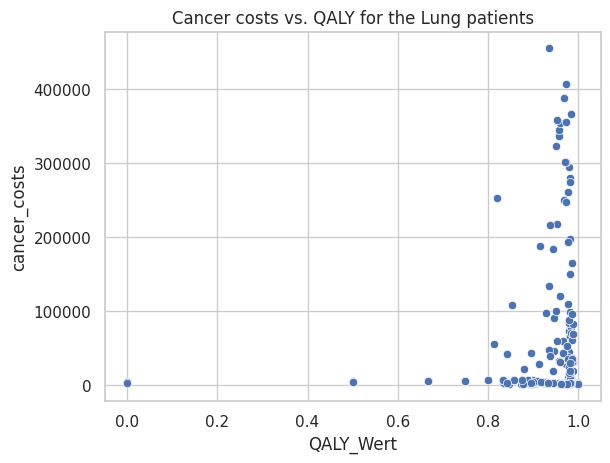

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Lung.png", format='png')


## B.5. Life Healthcare Kosten als Funktion vom QALY für Lungenkrebs Patienten

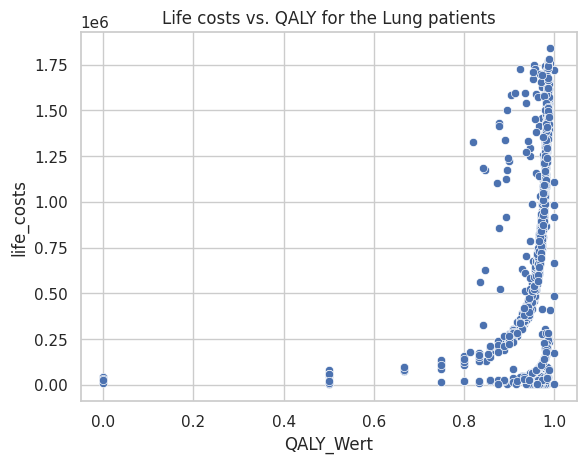

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_lung_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Lung patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Lung.png", format='png')

# C. Darmbrebs patients

## C.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Darmkrebs Patienten

In [ ]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Colorectal_Cancer"
;''')

df_colorectal_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_colorectal_QALY.head(5)
print(result)

         cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Colorectal_Cancer  42.260377 -72.582313  QALY  37.0   36.0   0.972973   
1  Colorectal_Cancer  42.296278 -71.052652  QALY  39.0   38.0   0.974359   
2  Colorectal_Cancer  41.753744 -71.098516  QALY  35.0   34.0   0.971429   
3  Colorectal_Cancer  42.405090 -72.554248  QALY  52.0   51.0   0.980769   
4  Colorectal_Cancer  42.656468 -71.160367  QALY  51.0   50.0   0.980392   

   life_costs  cancer_costs  
0   904391.44       1219.24  
1   811891.44        949.56  
2   721662.28       1219.24  
3    18674.72       2039.64  
4  1114095.56       2320.68  


## C.2. Geografische Verteilung der Darmkrebs Patienten

In [ ]:
map_massa_colorectal = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_colorectal = df_colorectal_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_colorectal)):
    folium.RegularPolygonMarker(coordinates_colorectal[i], radius = 3, fill_color = "blue", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_colorectal)
map_massa_colorectal

## C.3. Verteilung der vorhandenen QALY Werte im Datensatz bei Darmkrebs Patienten

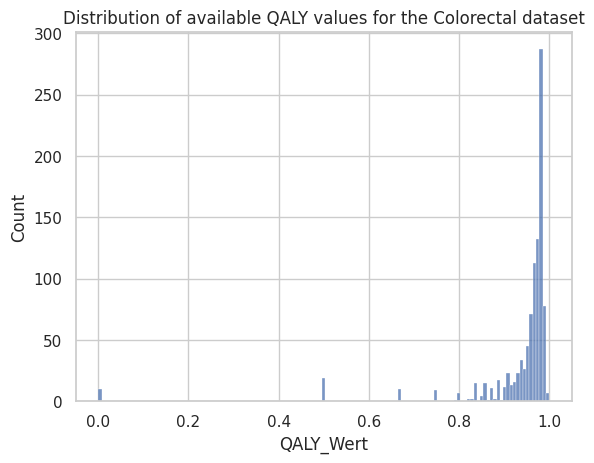

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_colorectal_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Colorectal dataset")

## C.4. Cancer Kosten als Funktion vom QALY für Darmkrebs Patienten

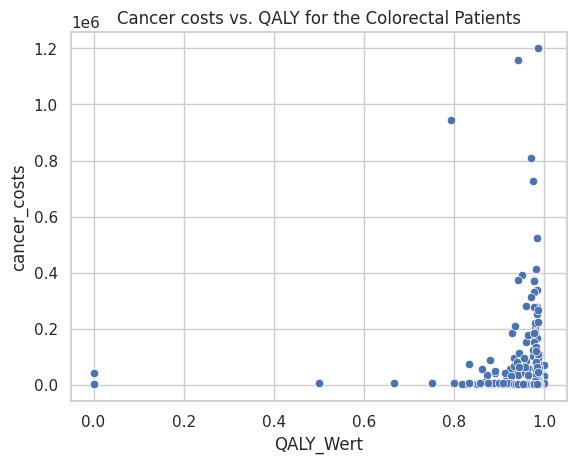

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Colorectal Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Colorectal.png", format='png')

## C.5. Life HEALTHCARE Kosten als Funktion vom QALY für Darmkrebs Patienten

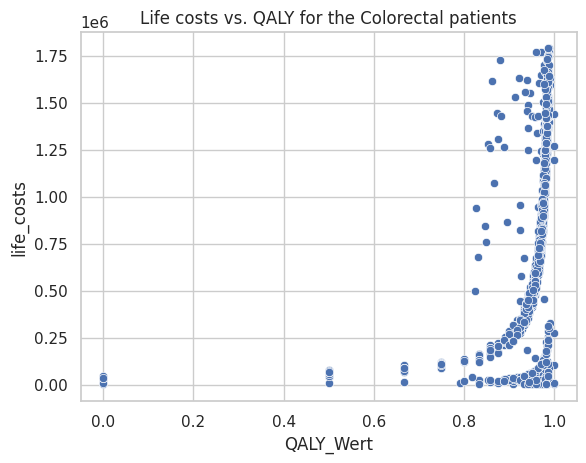

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_colorectal_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Colorectal patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Colorectal.png", format='png')

# D. Brustkrebs Patienten

## D.1. Einlesen der Faktentabelle und Berechnung der QALY Werte und der Kosten für Brustkrebs Patienten

In [ ]:
cur.execute('''
          SELECT
        f.cancer_type,
        f.patient_LAT,
        f.patient_LON,
        f.observations_CODE,
        f.observations_AGE,
        f.observations_VALUE,
        (CAST(f.observations_VALUE AS FLOAT)/CAST(f.observations_AGE AS FLOAT)) as QALY_Wert,
        (f.patient_HEALTHCARE_EXPENSES + f.patient_HEALTHCARE_COVERAGE) AS life_cost,
        (f.procedures_BASE_COST +
            f.medications_TOTALCOST +
            f.immunizations_BASE_COST +
            f.encounter_BASE_ENCOUNTER_COST) AS total_cost
        FROM facts_table f
        WHERE f.cancer_type LIKE "Breast_Cancer"
;''')

df_breast_QALY = pd.DataFrame(cur.fetchall(), columns = ['cancer_type', 'LAT', 'LON', 'QALY', 'Age', 'Value', 'QALY_Wert', 'life_costs', 'cancer_costs'])
result = df_breast_QALY.head(5)
print(result)

     cancer_type        LAT        LON  QALY   Age  Value  QALY_Wert  \
0  Breast_Cancer  42.359926 -71.113260  QALY  64.0   63.0   0.984375   
1  Breast_Cancer  42.257845 -72.026317  QALY  56.0   55.0   0.982143   
2  Breast_Cancer  42.204290 -71.818449  QALY  22.0   21.0   0.954545   
3  Breast_Cancer  42.150270 -70.904084  QALY  16.0   15.0   0.937500   
4  Breast_Cancer  42.292082 -71.784873  QALY  14.0   13.0   0.928571   

   life_costs  cancer_costs  
0  1479474.64       7069.03  
1  1493141.36       2579.00  
2    59245.64       2860.04  
3   411229.00       3539.92  
4   323370.68       3961.48  


## D.2. Geografische Verteilung der Brustkrebs Patienten

In [ ]:
map_massa_breast = folium.Map(location = MASSA_COORDINATES, width = "75%", zoom_start = 9) # max zoom: 18
coordinates_breast = df_breast_QALY[["LAT","LON"]].values.tolist()
for i in range(0, len(coordinates_breast)):
    folium.RegularPolygonMarker(coordinates_breast[i], radius = 3, fill_color = "green", fill_opacity = 0.5, number_of_sides = 12).add_to(map_massa_breast)
map_massa_breast

## D.3. Verteilung der vorhandenen QALY Werte im Datensatz bei Brustkrebs Patienten

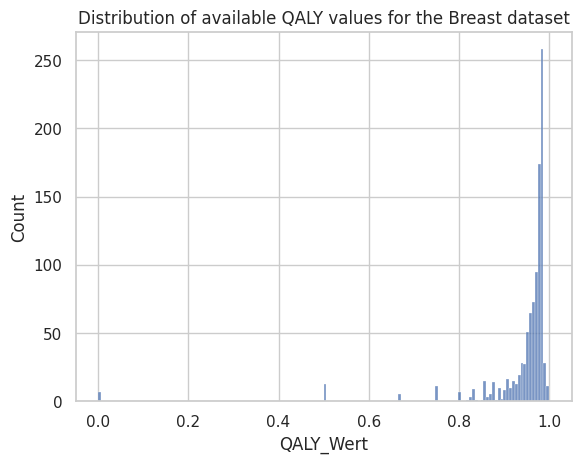

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.histplot(
    data=df_breast_QALY, x="QALY_Wert"
).set_title("Distribution of available QALY values for the Breast dataset")

## D.4. Cancer Kosten vs. QALY Werte für Brustkrebs Patienten

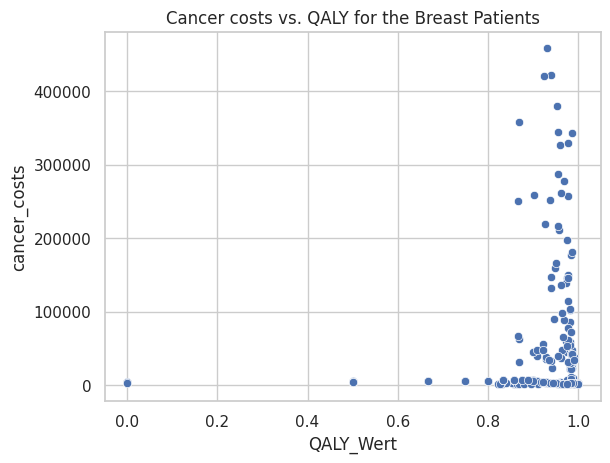

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="cancer_costs"
).set_title("Cancer costs vs. QALY for the Breast Patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Cancer_costs_vs_QALY_Breast.png", format='png')

## D.5. Life HEALTHCARE Kosten als Funktion vom QALY für Breast Patienten

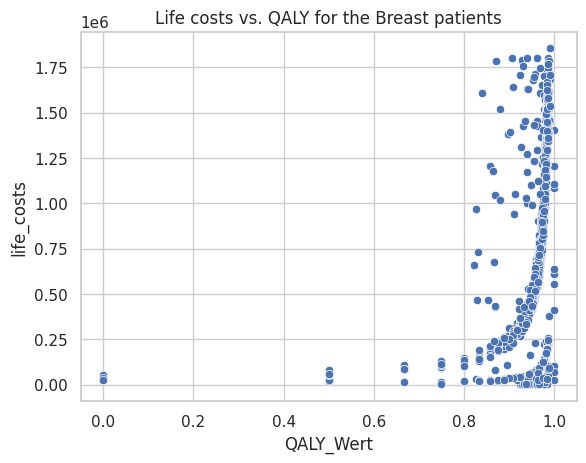

In [ ]:
sns.set_theme(style="whitegrid")

g = sns.scatterplot(
    data=df_breast_QALY, x="QALY_Wert",y="life_costs"
).set_title("Life costs vs. QALY for the Breast patients")
plt.savefig("/content/drive/MyDrive/calico_ma_repo/Documentation/Life_costs_vs_QALY_Breast.png", format='png')

## Statistische Auswertung

In [ ]:
# Gibt es signifikante Unterschiede in den krebsspezifischen und den lebenslangen Kosten?
# Vergleich dreier Gruppe, um die Voraussetzungen für einen parametrischen Test wie die einfaktorielle Varianzanalyse zu testen, muss die Frage nach 
# Varianzhomogenität und Normalverteilung in den Daten beantwortet werden.




Close the Sqlite connection

In [36]:
conn.close()
print("The Sqlite connection is closed")

The Sqlite connection is closed
